# CIFAR-100 Image Classification

## Installing the Libraries

In [1]:
# !pip install tensorflow
# !pip install keras
# !pip install h5py
# !pip install pandas
# !pip install numpy
# !pip install pickle
# !pip install scikit-image
# !pip install albumentations

## Importing the Libraries

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import tensorflow as tf
import keras
%matplotlib inline
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D 
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.transform import resize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import seaborn as sns
import cv2
import albumentations as albu

Using TensorFlow backend.


## Loading the CIFAR-100 Dataset

In [3]:
#function to open the files in the Python version of the dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        myDict = pickle.load(fo, encoding='latin1')
    return myDict

In [4]:
trainData = unpickle('train')

#type of items in each file
for item in trainData:
    print(item, type(trainData[item]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [5]:
print(len(trainData['data']))
print(len(trainData['data'][0]))

50000
3072


There are 50000 images in the training dataset and each image is a 3 channel 32 * 32 pixel image (32 * 32 * 3 = 3072).

In [6]:
print(np.unique(trainData['fine_labels']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


There are 100 different fine labels for the images (0 to 99).

In [7]:
print(np.unique(trainData['coarse_labels']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


There are 10 different coarse labels for the images (0 to 9).

In [8]:
print(trainData['batch_label'])

training batch 1 of 1


In [9]:
print(len(trainData['filenames']))

50000


In [10]:
testData = unpickle('test')
#testData

In [11]:
metaData = unpickle('meta')
#metaData

Meta file has a dictionary of fine labels and coarse labels.

In [12]:
#storing coarse labels along with its number code in a dataframe
category = pd.DataFrame(metaData['coarse_label_names'], columns=['SuperClass'])
category

,SuperClass
0,aquatic_mammals
1,fish
2,flowers
3,food_containers
4,fruit_and_vegetables
5,household_electrical_devices
6,household_furniture
7,insects
8,large_carnivores
9,large_man-made_outdoor_things


The above list shows coarse label number and name, which we are denoting as categories.

In [13]:
#storing fine labels along with its number code in a dataframe
subCategory = pd.DataFrame(metaData['fine_label_names'], columns=['SubClass'])
subCategory

,SubClass
0,apple
1,aquarium_fish
2,baby
3,bear
4,beaver
...,...
95,whale
96,willow_tree
97,wolf
98,woman


The above list shows fine label number and name, which we are denoting as subcategories.

In [14]:
X_train = trainData['data']
X_train

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

## Image Transformation for Tensorflow (Keras) and Convolutional Neural Networks

In [15]:
#4D array input for building the CNN model using Keras
X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)
#X_train

## Exploring the Images in the Dataset

Image number selected : 23147
Shape of image : (32, 32, 3)
Image category number: 3
Image category name: Food_containers
Image subcategory number: 28
Image subcategory name: Cup


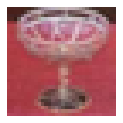

In [16]:
#generating a random number to display a random image from the dataset along with the label's number and name

rcParams['figure.figsize'] = 2,2

imageId = np.random.randint(0, len(X_train))

plt.imshow(X_train[imageId])

plt.axis('off')

print("Image number selected : {}".format(imageId))
print("Shape of image : {}".format(X_train[imageId].shape))
print("Image category number: {}".format(trainData['coarse_labels'][imageId]))
print("Image category name: {}".format(category.iloc[trainData['coarse_labels'][imageId]][0].capitalize()))
print("Image subcategory number: {}".format(trainData['fine_labels'][imageId]))
print("Image subcategory name: {}".format(subCategory.iloc[trainData['fine_labels'][imageId]][0].capitalize()))

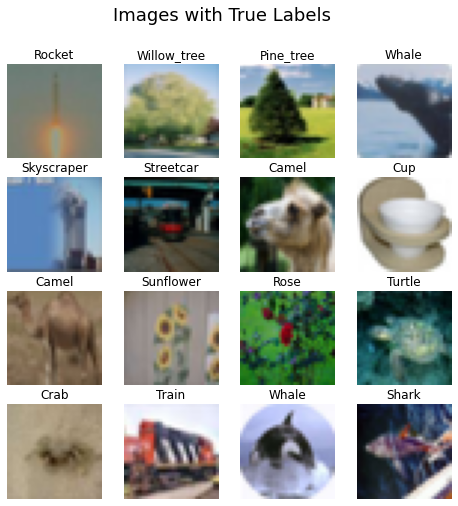

In [17]:
#16 random images to display at a time along with their true labels
rcParams['figure.figsize'] = 8,8

num_row = 4
num_col = 4

#to get 4 * 4 = 16 images together
imageId = np.random.randint(0, len(X_train), num_row * num_col)
#imageId

fig, axes = plt.subplots(num_row, num_col)
plt.suptitle('Images with True Labels', fontsize=18)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        axes[i,j].imshow(X_train[imageId[k]])
        axes[i,j].set_title(subCategory.iloc[trainData['fine_labels'][imageId[k]]][0].capitalize())
        axes[i,j].axis('off')

## Data Pre-processing

In [18]:
#transforming the testing dataset
X_test = testData['data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)
X_test.shape

(10000, 32, 32, 3)

In [19]:
y_train = trainData['fine_labels']
#y_train

y_test = testData['fine_labels']
#y_test

#### Converting class vectors to binary class matrices

In [20]:
n_classes = 100

y_train = to_categorical(y_train, n_classes)
#y_train

y_test = to_categorical(y_test, n_classes)
#y_test

#### Splitting the training dataset into training and validation datasets

In [21]:
#using stratified shuffle split to preserve the percentage of samples in each of the 100 classes
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=123)

for train_index, val_index in sss.split(X_train, y_train):
    X_train_data, X_val_data = X_train[train_index], X_train[val_index]
    y_train_data, y_val_data = y_train[train_index], y_train[val_index]

print("Number of training samples: ", X_train_data.shape[0])
print("Number of validation samples: ", X_val_data.shape[0])

Number of training samples:  40000
Number of validation samples:  10000


#### Constants

In [22]:
#resizing the images as per EfficientNetB0 to size (224, 224)
height = 224
width = 224
channels = 3

n_classes = 100
input_shape = (height, width, channels)

epochs = 15
batch_size = 8

In [23]:
def resize_img(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

#### Custom Data Generator class 

In [24]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, images, labels=None, mode='fit', batch_size=batch_size, dim=(height, width), channels=channels, n_classes=n_classes, shuffle=True, augment=False):
        
        #initializing the configuration of the generator
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
   
    #method to be called after every epoch
    def on_epoch_end(self):
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    #return numbers of steps in an epoch using samples and batch size
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    #this method is called with the batch number as an argument to obtain a given batch of data
    def __getitem__(self, index):
        #generate one batch of data
        #generate indexes of batch
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        
        #generate mini-batch of X
        X = np.empty((self.batch_size, *self.dim, self.channels))
        
        for i, ID in enumerate(batch_indexes):
            #generate pre-processed image
            img = self.images[ID]
            #image rescaling
            img = img.astype(np.float32)/255.
            #resizing as per new dimensions
            img = resize_img(img, self.dim)
            X[i] = img
            
        #generate mini-batch of y
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            
            #augmentation on the training dataset
            if self.augment == True:
                X = self.__augment_batch(X)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            
    #augmentation for one image
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p=0.5),
                                   albu.VerticalFlip(p=0.5),
                                   albu.GridDistortion(p=0.2),
                                   albu.ElasticTransform(p=0.2)])
        return composition(image=img)['image']
    
    #augmentation for batch of images
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch
    

In [25]:
train_data_generator = DataGenerator(X_train_data, y_train_data, augment=True)
valid_data_generator = DataGenerator(X_val_data, y_val_data, augment=False)

### Using pre-trained EfficientNetB0

In [26]:
# !pip install -U efficientnet

In [27]:
import efficientnet.keras as efn

efnb0 = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, classes=n_classes)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               128100    
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


In [28]:
optimizer = Adam(lr=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

In [29]:
#model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model_history = model.fit_generator(train_data_generator,
                                    validation_data=valid_data_generator,
                                    callbacks=[early_stop, rlrop],
                                    verbose=1,
                                    epochs=epochs)

#saving the trained model weights as data file in .h5 format
model.save_weights("cifar_efficientnetb0_weights.h5")

Epoch 1/15
5000/5000 [==============================] - 1598s 320ms/step - loss: 2.6624 - accuracy: 0.3432 - val_loss: 1.4835 - val_accuracy: 0.6754
Epoch 2/15
5000/5000 [==============================] - 1558s 312ms/step - loss: 1.6425 - accuracy: 0.5491 - val_loss: 0.4246 - val_accuracy: 0.7424
Epoch 3/15
5000/5000 [==============================] - 1561s 312ms/step - loss: 1.3483 - accuracy: 0.6242 - val_loss: 0.9113 - val_accuracy: 0.7580
Epoch 4/15
5000/5000 [==============================] - 1552s 310ms/step - loss: 1.1800 - accuracy: 0.6643 - val_loss: 0.3704 - val_accuracy: 0.7801
Epoch 5/15
5000/5000 [==============================] - 1563s 313ms/step - loss: 1.0609 - accuracy: 0.6986 - val_loss: 0.2021 - val_accuracy: 0.7852
Epoch 6/15
5000/5000 [==============================] - 1555s 311ms/step - loss: 0.9794 - accuracy: 0.7151 - val_loss: 0.7813 - val_accuracy: 0.7905
Epoch 7/15
5000/5000 [==============================] - 1563s 313ms/step - loss: 0.9013 - accuracy: 0.7399

In [31]:
#saving the trained model as data file in .h5 format
model.save('cifar_efficientnetb0_model.h5')

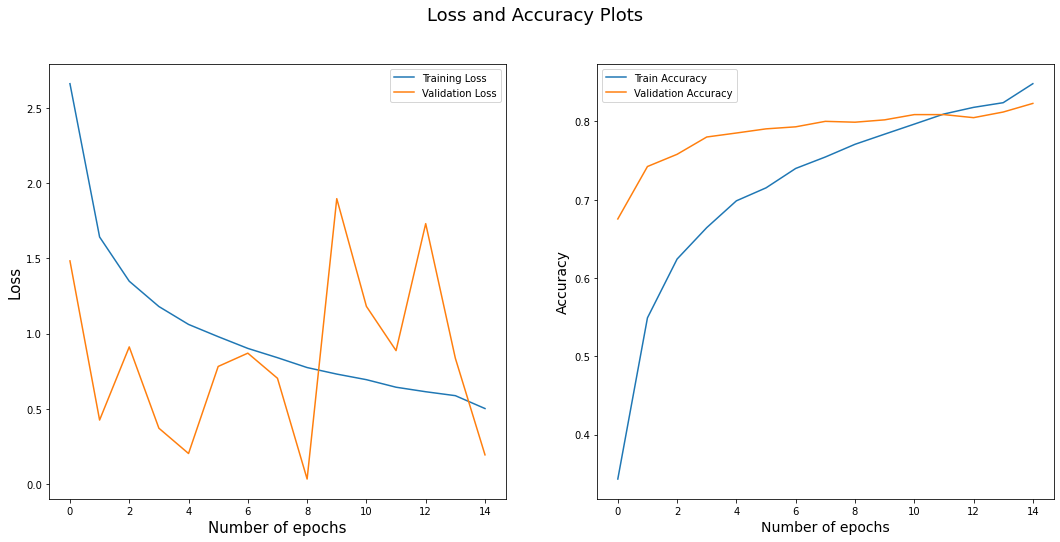

In [32]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

## Model Evaluation

In [33]:
valid_loss, valid_accuracy = model.evaluate_generator(generator=valid_data_generator, verbose=1)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

1250/1250 [==============================] - 85s 68ms/step
Validation Accuracy:  82.3 %


## Model Prediction

In [34]:
y_pred = model.predict_generator(DataGenerator(X_test, mode='predict', augment=False, shuffle=False), verbose=1)
y_pred = np.argmax(y_pred, axis=1)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

1250/1250 [==============================] - 78s 63ms/step
Test Accuracy:  81.79 %


## Confusion Matrix

In [35]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(cm)

[[93  0  0 ...  0  0  0]
 [ 0 92  0 ...  0  0  0]
 [ 0  0 81 ...  0  0  0]
 ...
 [ 0  0  0 ... 88  0  0]
 [ 0  0  3 ...  0 66  0]
 [ 0  0  0 ...  0  1 84]]


In [36]:
#report to see which category has been predicted incorectly and which has been predicted correctly
target = ["Category {}".format(i) for i in range(n_classes)]
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target))

              precision    recall  f1-score   support

  Category 0       0.89      0.93      0.91       100
  Category 1       0.88      0.92      0.90       100
  Category 2       0.60      0.81      0.69       100
  Category 3       0.75      0.82      0.78       100
  Category 4       0.72      0.71      0.71       100
  Category 5       0.80      0.78      0.79       100
  Category 6       0.87      0.90      0.88       100
  Category 7       0.92      0.78      0.84       100
  Category 8       0.91      0.96      0.94       100
  Category 9       0.89      0.92      0.91       100
 Category 10       0.71      0.55      0.62       100
 Category 11       0.52      0.39      0.45       100
 Category 12       0.85      0.80      0.82       100
 Category 13       0.83      0.80      0.82       100
 Category 14       0.95      0.82      0.88       100
 Category 15       0.83      0.92      0.87       100
 Category 16       0.83      0.83      0.83       100
 Category 17       0.90    

## Visualizing the Predictions

In [37]:
#dataframe of predictions
prediction = pd.DataFrame(y_pred)
prediction.head()

,0
0,68
1,33
2,55
3,51
4,71


True Label: Whale
Predicted Label: Whale


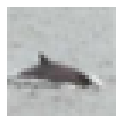

In [38]:
#generating a random number to display a random image from the dataset along with the true and predicted label
imageId = np.random.randint(0, len(X_test))

rcParams['figure.figsize'] = 2,2

plt.imshow(X_test[imageId])

plt.axis('off')

print("True Label: " + str(subCategory.iloc[testData['fine_labels'][imageId]][0].capitalize()))
print("Predicted Label: " + str(subCategory.iloc[prediction.iloc[imageId]]).split()[2].capitalize())

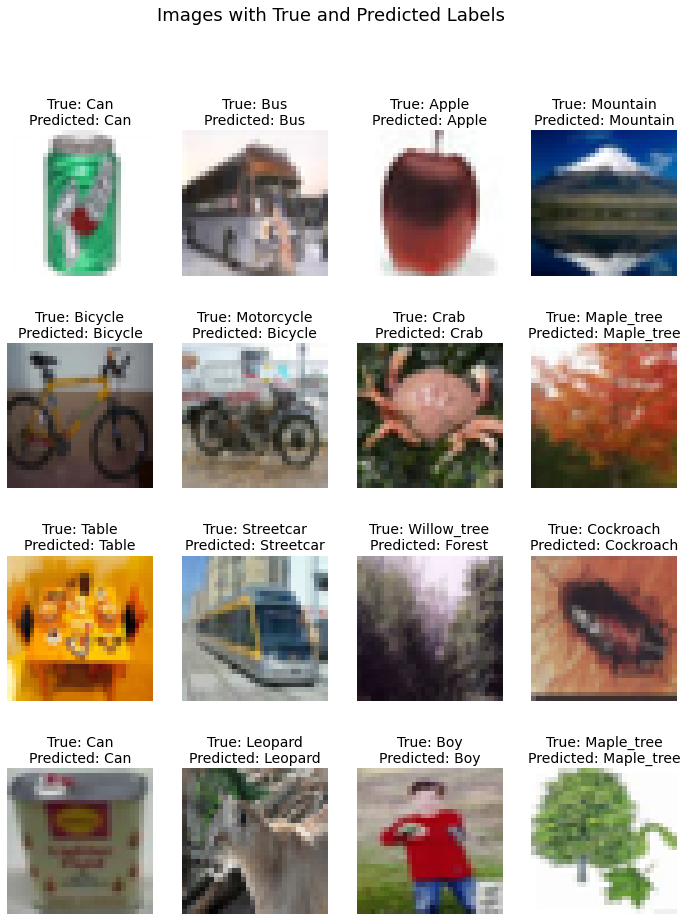

In [39]:
#16 random images to display at a time along with their true and random labels
rcParams['figure.figsize'] = 12,15

num_row = 4
num_col = 4

imageId = np.random.randint(0, len(X_test), num_row * num_col)

fig, axes = plt.subplots(num_row, num_col)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        axes[i,j].imshow(X_test[imageId[k]])
        axes[i,j].set_title("True: " + str(subCategory.iloc[testData['fine_labels'][imageId[k]]][0]).capitalize() 
                             + "\nPredicted: " + str(subCategory.iloc[prediction.iloc[imageId[k]]]).split()[2].capitalize(), 
                            fontsize=14)
        axes[i,j].axis('off')
        fig.suptitle("Images with True and Predicted Labels", fontsize=18) 

plt.show()

## Testing the model

In [40]:
#function to resize the image
def resize_test_image(test_img):

    img = cv2.imread(test_img)
    #plt.imshow(img)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img_RGB)
    resized_img = cv2.resize(img_RGB, (224, 224))
    #plt.imshow(resized_img)
    resized_img = resized_img / 255.
    #plt.imshow(resized_img)
    return resized_img
    
#resize_test_image('orange.jpeg')

In [41]:
#function to get prediction for test image from the model
def predict_test_image(test_img):
    
    resized_img = resize_test_image(test_img)
    prediction = model.predict(np.array([resized_img]))
    
    return prediction

#predict_test_image('orange.jpeg')

In [42]:
#function to get the sorted prediction
def sort_prediction_test_image(test_img):
    
    prediction = predict_test_image(test_img)
    
    index = np.arange(0,100)
    
    for i in range(100):
        for j in range(100):
            if prediction[0][index[i]] > prediction[0][index[j]]:
                temp = index[i]
                index[i] = index[j]
                index[j] = temp
                
    return index

#sort_prediction_test_image('orange.jpeg')

In [43]:
#function to get the dataframe for top 5 predictions
def df_top5_prediction_test_image(test_img):
    
    sorted_index = sort_prediction_test_image(test_img)
    prediction = predict_test_image(test_img)
    
    subCategory_name = []
    prediction_score = []
    
    k = sorted_index[:6] 
    
    for i in range(len(k)):
        subCategory_name.append(subCategory.iloc[k[i]][0])
        prediction_score.append(round(prediction[0][k[i]], 2))
        
    df = pd.DataFrame(list(zip(subCategory_name, prediction_score)), columns=['Label', 'Probability'])  
    
    return df

#df_top5_prediction_test_image('orange.jpeg')

In [44]:
#function to get the plot for top 5 predictions 
def plot_top5_prediction_test_image(test_img):
    
    fig, axes = plt.subplots(1, 2, figsize=(15,4))
    fig.suptitle("Prediction", fontsize=18)
    
    new_img = plt.imread(test_img)
    axes[0].imshow(new_img)
    axes[0].axis('off')
    
    data = df_top5_prediction_test_image(test_img)
    x=df_top5_prediction_test_image(test_img)['Label']
    y=df_top5_prediction_test_image(test_img)['Probability']
    
    axes[1] = sns.barplot(x=x, y=y, data=data, color="green")
    
    plt.xlabel('Label', fontsize=14)
    plt.ylabel('Probability', fontsize=14)
    
    plt.ylim(0,1.0)
    
    axes[1].grid(False)
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)
    axes[1].spines["bottom"].set_visible(False)
    axes[1].spines["left"].set_visible(False)
    
    plt.show()

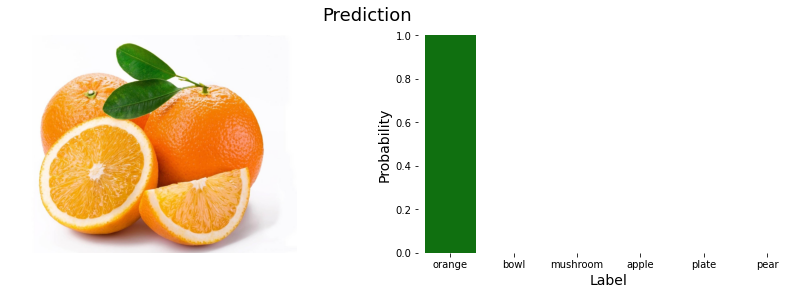

In [45]:
plot_top5_prediction_test_image('orange.jpeg')

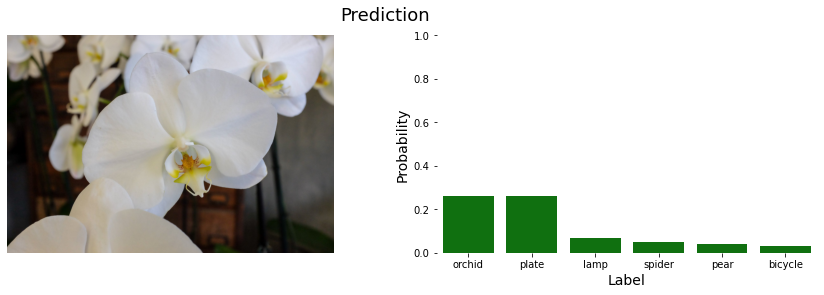

In [46]:
plot_top5_prediction_test_image('Orchid.jpg')

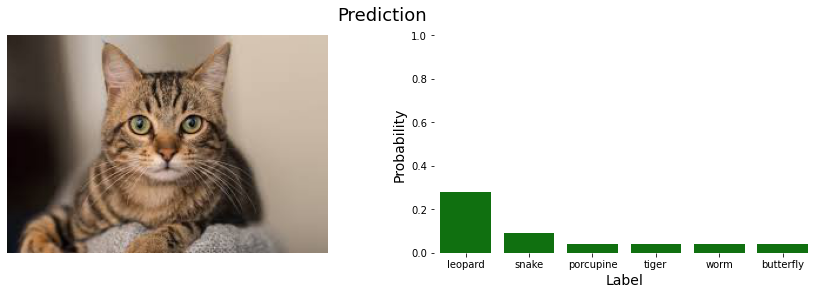

In [47]:
plot_top5_prediction_test_image('cat.jpeg')

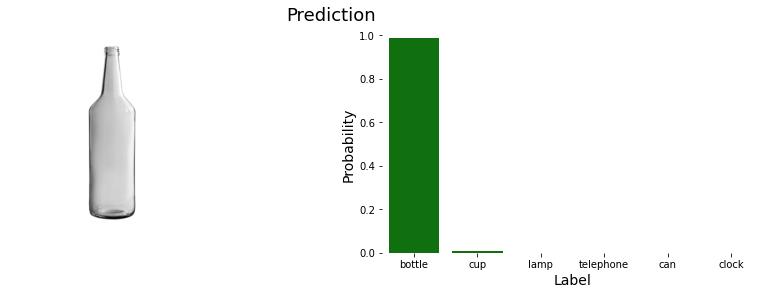

In [48]:
plot_top5_prediction_test_image('bottle.jpeg')

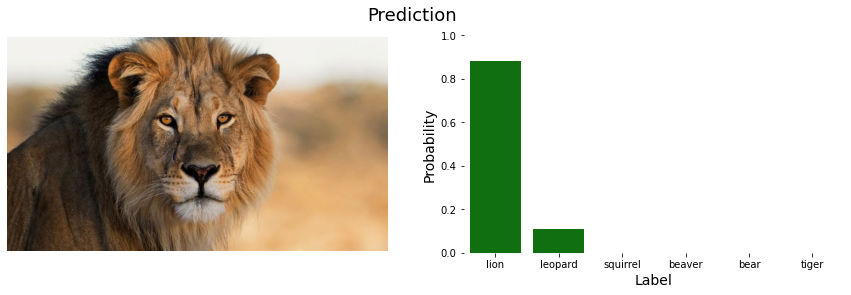

In [49]:
plot_top5_prediction_test_image('lion.jpg')

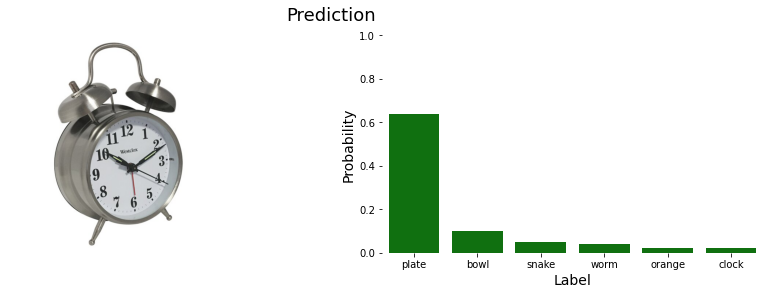

In [50]:
plot_top5_prediction_test_image('clock.jpg')

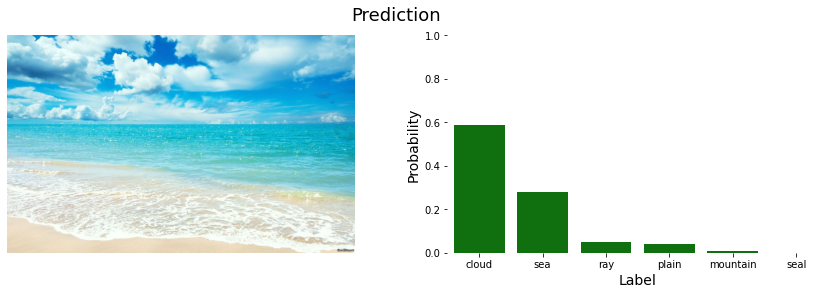

In [51]:
plot_top5_prediction_test_image('sea.jpg')

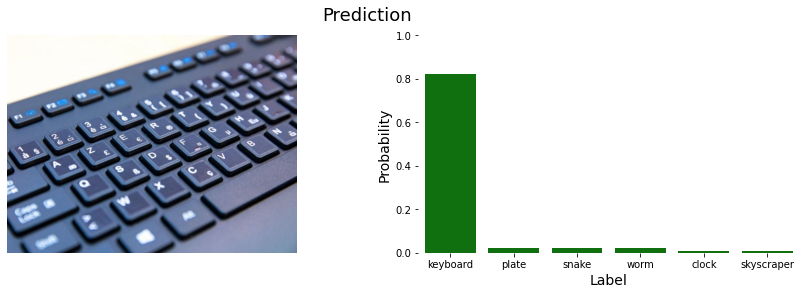

In [52]:
plot_top5_prediction_test_image('keyboard.jpeg')

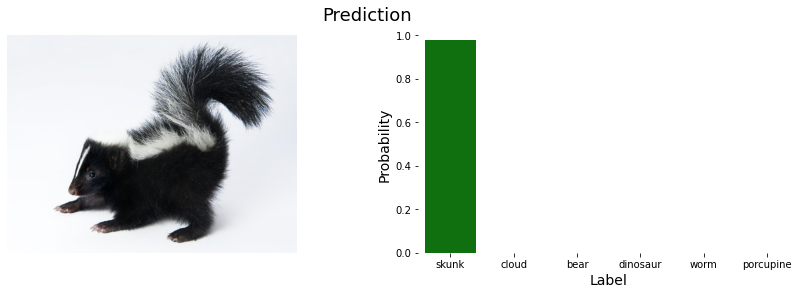

In [53]:
plot_top5_prediction_test_image('skunk.jpg')

In [54]:
#saving the trained model as data file in .h5 format
model.save('cifar_efficientnetb0_model.h5')